In [1]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [2]:
from dataset_creation import dataset_creator as data_generator
from feature_extract import turntake_extractor as feat_extractor
import constants

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


In [3]:
# TEST Variables
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean = False
from_store= True
filter_missing_data=True
transform_features=False
indiv_missing_data=['1_018_35', '2_006_15', '2_006_33', '2_011_29', '2_036_35', '2_044_8', '2_044_30', '3_004_37', '3_007_11', '3_052_27', '3_052_28', '3_058_25', '3_060_1', '3_068_15']
group_missing_data=['1_018', '2_006', '2_006', '2_011', '2_036', '2_044', '2_044', '3_004', '3_007', '3_052', '3_052', '3_058', '3_060', '3_068']

manifest="group"
if manifest == "indiv":
    features = ["#turns", "%talk", "mean_turn", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.indiv_tt_X_path
    missing_data=indiv_missing_data
else:
    features = ["var_#turn", "var_dturn", "conv_eq", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.group_tt_X_path
    missing_data=group_missing_data

In [4]:
# Annotation Reader
reliable_ids, reliable_convqs, reliable_kappas = data_generator.get_annotation_realiable_labels(agreeability_thresh, manifest, annotators, zero_mean)
print("Total Groups in Analysis - " + str(len(reliable_ids)))

ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False
Total Groups in Analysis - 81


In [5]:
# Get Turn-Taking feaures for IDs (group/ indiv)
if from_store:
    tt_X = pd.read_csv(store_file, sep=',', header=None).values
#     tt_X.columns = features
#     tt_X.set_index(reliable_ids)
else:
    tt_X = feat_extractor.get_tt_dataset_feats_for(reliable_ids, features, manifest)

In [6]:
if not from_store:
    # Save Dataset -- tt_X
    np.savetxt(store_file, tt_X, delimiter=",")

In [7]:
# Transform Features
if transform_features:
    from sklearn.preprocessing import StandardScaler
    tt_X = StandardScaler().fit_transform(tt_X)
    reliable_convqs = StandardScaler().fit_transform(np.array(reliable_convqs).reshape(-1, 1))

In [8]:
# Get groups sizes (for indiv and group)
group_sizes = data_generator.get_group_sizes_for_ids(reliable_ids, manifest)

In [9]:
tt_X = pd.DataFrame(data=tt_X, index=reliable_ids, columns=features) 
tt_X["convq"] = reliable_convqs
tt_X["group_sizes"] = group_sizes

In [10]:
#Filter Dataset - Remove Incompelete Data
print("Before Filter: Feature Set -> " + str(tt_X.shape))
if filter_missing_data:
    final_reliable_ids = [x for x in reliable_ids if x not in missing_data]
    tt_X = tt_X[tt_X.index.isin(final_reliable_ids)]
print("After Filter: Feature Set -> " + str(tt_X.shape))

Before Filter: Feature Set -> (81, 11)
After Filter: Feature Set -> (74, 11)


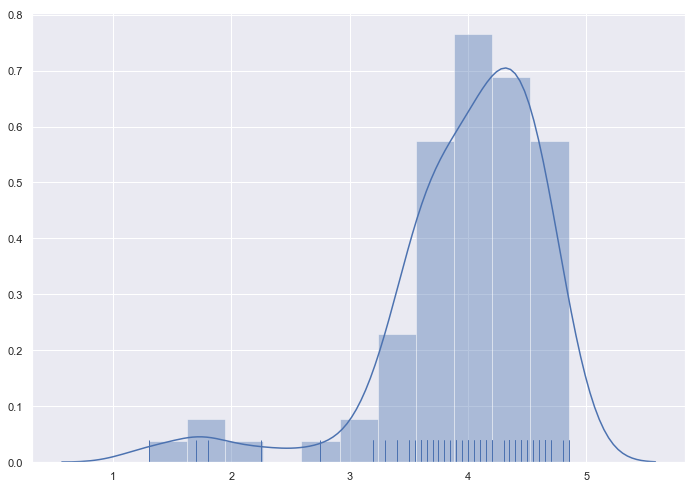

In [11]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

In [12]:
# Statistical Tests:(Main Question)
# Do Turn-Taking features have a significant effect on the Percieved Conversation Quality of the Group?
# TT Features can be categorised into three categories -> Equality, Fluency and Synchronisation
#
# (Sub Question)
# Does Conversation Equality have a significant effect on the Percieved Conversation Quality of the Group?
#  1. Use Features "var_#turn", "var_dturn", "conv_eq". 
#
# (Sub Question)
# Does Conversation Fluency have a significant effect on the Percieved Conversation Quality of the Group?
# 1. Use Features "mean_silence", "%silence", "#bc". 
# 
# (Sub Question)
# Does Conversation Synchronisation have a significant effect on the Percieved Conversation Quality of the Group?
# 1. Use Features "%overlap", "#suc_interupt", "#un_interupt". 
# 
# For all above questions, after (1), perform below steps,
#  2. Fit a Quantile Least Square Regression model on the features vs the convq score.
#  3. Analyse p-value significance @ p<0.05
#  4. Check the co-efficients for informations.

In [15]:
test_feats=["const", "var_#turn", "var_dturn", "conv_eq", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]

conv_eq_feats=["const", "group_sizes", "conv_eq"]
conv_fl_feats=["const", "group_sizes", "%silence", "#bc"]
conv_sy_feats=["const", "group_sizes", "%overlap", "#suc_interupt", "#un_interupt"]

full_test_feats=["const", "group_sizes", "conv_eq", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]

test_feats=conv_sy_feats

In [16]:
# Experiment Below

# Ordinary Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

print("significance @ 0.05/3 = 0.02 after Bonferroni correction for 3 tests (eq, fluency, sync)")
print()
print()
print("~~~~~~~~~~~~~~~~~~~~~~~ Conversation Equality Test ~~~~~~~~~~~~~~~~~~~~~~~")
X = sm.add_constant(tt_X)
model = sm.OLS(X["convq"], X.loc[:,conv_eq_feats])
results = model.fit()
print(results.summary())
print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Conversation Fluency Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = sm.OLS(X["convq"], X.loc[:,conv_fl_feats])
results = model.fit()
print(results.summary())
print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Conversation Synchronisation Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = sm.OLS(X["convq"], X.loc[:,conv_sy_feats])
results = model.fit()
print(results.summary())

significance @ 0.05/3 = 0.02 after Bonferroni correction for 3 tests (eq, fluency, sync)


~~~~~~~~~~~~~~~~~~~~~~~ Conversation Equality Test ~~~~~~~~~~~~~~~~~~~~~~~
                            OLS Regression Results                            
Dep. Variable:                  convq   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.133
Date:                Wed, 20 May 2020   Prob (F-statistic):              0.328
Time:                        17:33:43   Log-Likelihood:                -76.910
No. Observations:                  74   AIC:                             159.8
Df Residuals:                      71   BIC:                             166.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t

In [ ]:
# Quantile Regression
X = sm.add_constant(tt_X)

model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_eq_feats])
results = model.fit(q=.4)
print(results.summary())

In [ ]:
# Generalised Linear Regression
X = sm.add_constant(tt_X)

model = sm.GLM(X["convq"], X.loc[:,full_test_feats])
results = model.fit()
print(results.summary())

In [ ]:
for curr_feat in full_test_feats:
    if curr_feat not in ["convq", "const"]:
        
        model_ols = sm.OLS(X["convq"], sm.add_constant(X[curr_feat])).fit().params
        model_qnt = sm.regression.quantile_regression.QuantReg(X["convq"], sm.add_constant(X[curr_feat])).fit(q=0.4).params

        # scatter-plot data
        ax = X.plot(x='convq', y=curr_feat, kind='scatter', c="black")

        # plot regression line on the same axes, set x-axis limits
        ax.plot(X["convq"].values, model_ols["const"] + model_ols[curr_feat] * X["convq"].values)
        ax.plot(X["convq"].values, model_qnt["const"] + model_qnt[curr_feat] * X["convq"].values)
        ax.legend(['OLS', 'QUANTILE'])
        ax.set_xlim([1, 5])